# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.


1. a) Accuracy- Accuracy would be preferrable when the data set is balanced- for example: training to recognise cats or dogs and there is a good balance of data for cats and for dogs (50% of the images are cats and 50% dogs). b) Precision- Precision is a useful metric when the cost of false positves are high- for example when a machine learning algorithm determines if a transaction is fraudulent or not, a false positive would incorrectly determine a legitimate transaction as fraudulent, making the bank look bad. Hence having a high precision is an important metric in this case. c) Recall- this is most useful when the cost of false negatives is high. For example, machine learning algorithms for cancer detection, returning a test negative where it should be positive. Here having good recall for this algorithm is crucial as the cost of misdiagnosing a patient is fatal.

2. a) Accuracy is not the best when there is an imbalanced data set. For example, consider a machine learning algorithm for spam detection which does not occur that frequently, 5% of the time. This means that, in 100 emails, by simply predicting no spam in all of them would achieve a 95% accuracy. This is a high accuracy but the algorithm simply fails to do anything at all. b) Precision would fail when negatives are important for the data set. For example with the cancer algorithm from 1c), the algorithm could have a high precision, but still consistently misdiagnose patients. c) Recall fails when the cost of a false positive is high, as in the example from 1b). Here the company could have a high recall metric while having a high number of false negatives as well.

3. The F1 score is particularly helpful when the costs of false positives and false negatives is high. For example, an automated hiring screening process- a false positive (accepting a unsuitable candidate) wastes company resources while a false negative (rejecting a suitable candidate) could prevent the best applicant from joining the company. Hence, using the F1 score in this case would ensure that optimising recall or precision metrics does not come at the cost of each other. The algorithm can improve and still give value to both false positives and false negatives.

## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


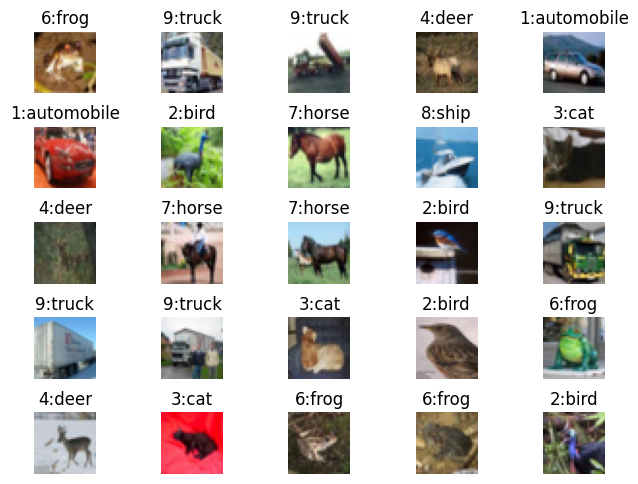

In [2]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

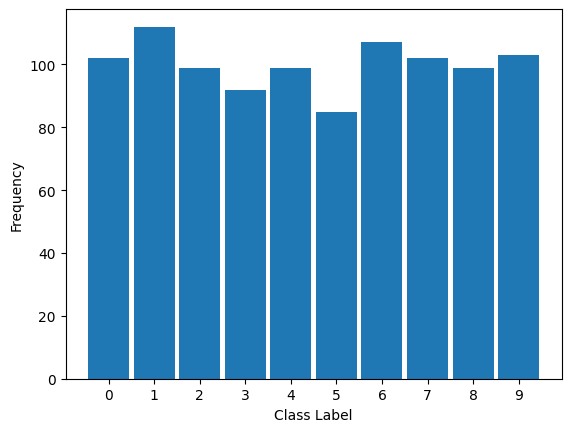

In [ ]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [ ]:
# Your answer here
print(train_X.shape)

(1000, 32, 32, 3)


**Q 2.1.1** What does each value in the tuple that was printed out mean?

*This tells us how many elements are present in each dimension. In this case there are 1000 images, each 32 pixels high by 32 pixels wide, and 3 would imply that the image is not in greyscale, but RGB colour.*

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [3]:
# Your answer here
def flatten_cifar10(samples):
    return samples.reshape((len(samples), 32*32*3))

train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X)
print(train_X.shape)

(1000, 3072)


## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [ ]:
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression() # create the logistic regression object
modelLR = modelLR.fit(train_X, train_y) # fit on training data
print("Training score:", modelLR.score(train_X, train_y))
print("Testing score: ", modelLR.score(test_X, test_y))

Training score: 0.948
Testing score:  0.257


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

No, the model does not work well in my opinion, despite achieving great results for training data. This is because for other datasets it does not score well at all with a great discrepancy between both training and test scores. The model is likely overfitting as it is able to score well on the training data, but not overall. This means that it likely focuses and latches onto some patterns that are true for the training data but not as a whole.

### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [ ]:
from sklearn import tree

train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies

for d in tqdm(range(1,16)): # loop over tree depths
    train_perfs = [] # store interem train scores
    test_perfs = []  # store interem test scores
    for n in range(1,11):   # loop over random initializations
        modelDT = tree.DecisionTreeClassifier(max_depth=d, splitter = "random", random_state = n)
        modelDT = modelDT.fit(train_X, train_y)
        train_perfs.append(modelDT.score(train_X, train_y))
        test_perfs.append(modelDT.score(test_X, test_y))

    # append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))


100%|██████████| 15/15 [00:50<00:00,  3.37s/it]


**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

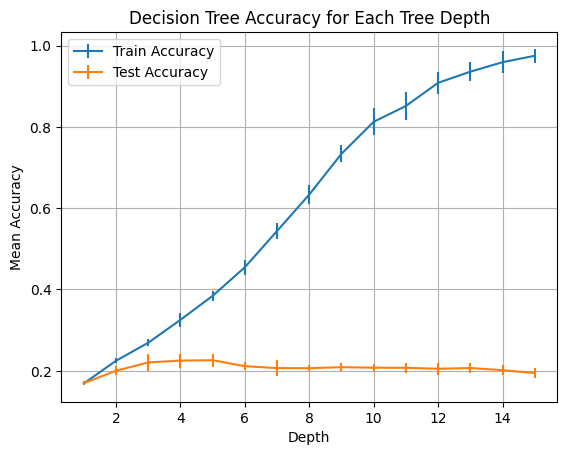

In [ ]:
plt.errorbar(range(1,16), train_acc_mean, yerr = train_acc_std, label = 'Train Accuracy')
plt.errorbar(range(1,16), test_acc_mean, yerr = test_acc_std, label = 'Test Accuracy')
plt.title('Decision Tree Accuracy for Each Tree Depth')
plt.ylabel("Mean Accuracy")
plt.xlabel("Maximum Depth")
plt.legend()
plt.grid()
plt.show()

**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?
2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?
3. At what depth do models start to overfit the training data?


1. For the variation in performance with the training set, yes, the higher the depth the greater the accuracy achieved, with a slight plateau at around 12 maximum depth. However, for the test accuracy not as much, with it fluctuating around 0.2 and a peak at 4 max_depth.
2. The model at 15 performed the best on the training set. This is likely due to at a depth of 15, a decision tree would have a huge set of characteristics to split into and tighly and accurately fit all the training data. For the test set the max_depth that performed best was at max_depth = 4.
3. The models start to overfit the training data at a depth of 4, this is likely because at larger depths, it overclassifies the images given by the training data and can no longer be adapted to correctly classify slightly different ones. At four, the model likely captures the key differences between each label of classification, correctly grouping different images, while still being able to differentiate between labels.

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8)) # storing it in an np array instead of a list makes it easier
test_acc_mean, test_acc_std = np.zeros((10,8)), np.zeros((10,8))

n_trees = [10 ,20, 30, 40, 50, 60, 70, 80, 90, 100]
depths = [1,3,5,7,9,11,13,15]

for tree_idx, n_trees in tqdm(enumerate(n_trees), total=len(n_trees)):
    for d_idx, d in enumerate(depths):
        train_perfs = []
        test_perfs = []
        for n in range(1,6):
          modelRFC = RFC(n_trees, max_depth=d, random_state=n)
          modelRFC = modelRFC.fit(train_X, train_y)
          train_perfs.append(modelRFC.score(train_X, train_y))
          test_perfs.append(modelRFC.score(test_X, test_y))

        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)

100%|██████████| 10/10 [12:19<00:00, 73.97s/it] 


Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

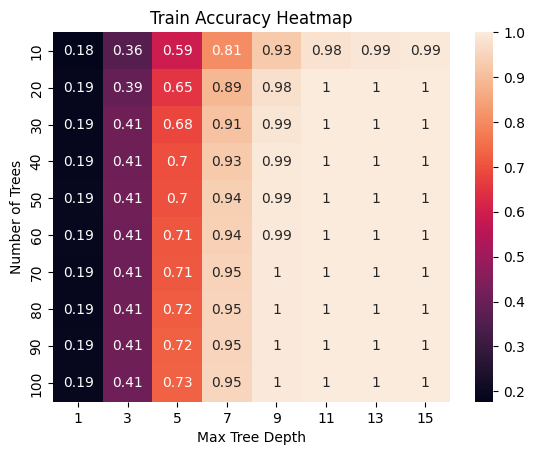

<Figure size 640x480 with 0 Axes>

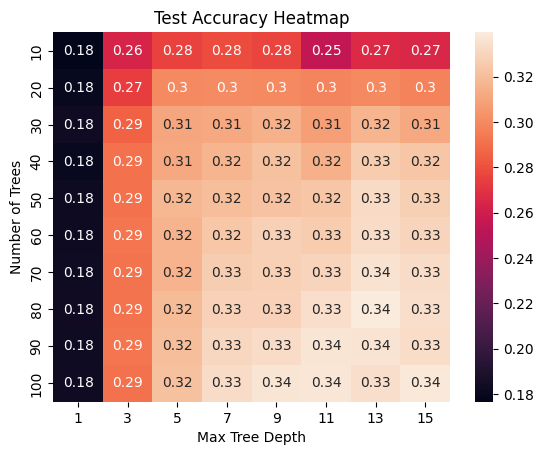

In [ ]:
import seaborn as sns
# Figure 1
plt.figure()
sns.heatmap(train_acc_mean, annot=True, xticklabels= [1,3,5,7,9,11,13,15], yticklabels=[10,20,30,40,50,60,70,80,90,100]) # create seaborn heatmap with annotations
plt.xlabel('Max Tree Depth')
plt.ylabel('Number of Trees')
plt.title('Train Accuracy Heatmap')
plt.show()

# Figure 2
plt.figure()
plt.figure()
sns.heatmap(test_acc_mean, annot=True, xticklabels=[1,3,5,7,9,11,13,15], yticklabels=[10,20,30,40,50,60,70,80,90,100]) # create seaborn heatmap with annotations
plt.xlabel('Max Tree Depth')
plt.ylabel('Number of Trees')
plt.title('Test Accuracy Heatmap')
plt.show()


**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?
2. What model performs best on the train set? What model performs best on the test set?
3. What model would you choose to deploy and why?

1. With a larger tree depth than 1, all increases in respect to n_trees for each max_depth leads to an increase in test and train accuracy. However as both of these get bigger the increase is decreasing or having no increase most of the time. Also worth noting that with max_depth = 13, the training accuracy even decreases as the number of tries increases. Similarly, when max_depth is increased for over 30 trees, the test accuracy starts to oscillate a bit, indicating overfitting. There is a stagnation in test accuracy but still an increase with training accuracy.
2. Most models with larger tree depth and number of trees get an accuracy of 1, even if its not exactly one it is so high that the program rounds it to 1. However for the test set, a couple of different models acheive the best performance of 0.34 accuracy, including: (9,100), (11,90), (11,100), (13,70), (13,80), (13,90) and (15,100). It could be worth emphasizing that except for (15,100) it seemed that the largest the tree depth, the lowest the number of trees required to achieve the best recorded accuracy, even demonstrating a possible overfit with (13,100) having a lower test accuracy of 0.33.
3. I would likely choose to deploy, among the best test accuracies, something along the middle so (13,70) or (11,90). The reason for this is because the heat map demonstrates that increases in both hyperparametes leads to stagnation and even a possible decrease of test accuracy, meaning an overfit. Therefore, for different test data, it could even be that (13,70) or (11,90) could show lower results as well. Nonetheless based on this set, I would most closely observe these two models.

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = [
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100],
    },
    {'kernel': ['poly'],
     'C': [0.1, 1, 10, 100],
     'degree': [2,3,4],
     'gamma': [0.01, 0.1, 1, 10, 100]
    },
    {'kernel': ['rbf'],
     'C': [0.1, 1, 10, 100],
     'gamma': [0.01, 0.1, 1, 10, 100]}
]

# create the cross-validation object
optimal_params_svm = GridSearchCV(
    estimator = SVC(),             # support vector classifier instance
    param_grid = param_grid_svm,              # grid search params
    cv = 5,                      # k=5 CV
    scoring='accuracy',            # use accuracy measure for best hyperparameters
)

optimal_params_svm.fit(train_X, train_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)

**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

1. There are only 4 C-values for linear. 4 C-values, 3 degrees and 5 Gamma-values for each poly (4*3*5 =60 combinations). 4 C-values and 5 Gamma-values for each rbf (4*5= 20). So in total 84 (4+60+20) cobinations of parameters
2. With 5-fold validation, in total 84*5, or 420 models trained

**Q 3.4.3**
Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

modelSVC = SVC(kernel = 'rbf', C = 10, gamma = 0.1) # create model
modelSVC = modelSVC.fit(train_X, train_y)  # train model
print("Training score:", modelSVC.score(train_X, train_y))
print("Testing score: ", modelSVC.score(test_X, test_y))

Training score: 1.0
Testing score:  0.089


## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.
When analyzing the training and inference speed of machine learning models, it is crucial to measure how long a model takes to:

1. Train (Fit): The time required to learn from the training dataset.
2. Infer (Predict): The time required to classify a new image (for image classification) or make a prediction on new data.

The perf_counter() function is useful for this because it provides high-precision timing measurements, making it ideal for benchmarking models.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*



In [9]:
from time import perf_counter # used to compute intervals
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import tree

n_train, n_test = 5000, 5000
train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test) # get data
train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X) # flatten images

# set up lists to store scores and times
train_scores = []
test_scores = []
fit_times = []
inf_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """ Trains, times and evaluates a given instantiated model on data """

    start = perf_counter()               # check current (start) time
    model = model.fit(train_X, train_y)  # perform some code that you want to time
    end = perf_counter()                 # check current (end) time
    fit_time = end-start                 # compute interval

    # time inference over train score
    start = perf_counter()
    train_score = model.score(train_X, train_y)
    end = perf_counter()
    train_score_time = end-start

    # time inference over test score
    start = perf_counter()
    test_score = model.score(test_X, test_y)
    end = perf_counter()
    test_score_time = end-start

    return train_score, test_score, fit_time, train_score_time, test_score_time

# create models
modelLR = LogisticRegression()

modelDT = tree.DecisionTreeClassifier(max_depth=4, splitter = "random", random_state = 1)
modelRFC = RFC(70, max_depth=13, random_state=1)
modelSVC = SVC(kernel = 'rbf', C = 10, gamma = 0.1)

for model in tqdm([modelLR, modelDT, modelRFC, modelSVC]):
    train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(model, train_X, train_y, test_X, test_y)
    train_scores.append(train_score)
    test_scores.append(test_score)
    fit_times.append(fit_time / len(train_X))
    inf_times.append({
      'train': train_score_time / len(train_X),
      'test': test_score_time / len(test_X)
    })

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [04:53<00:00, 73.44s/it] 


Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

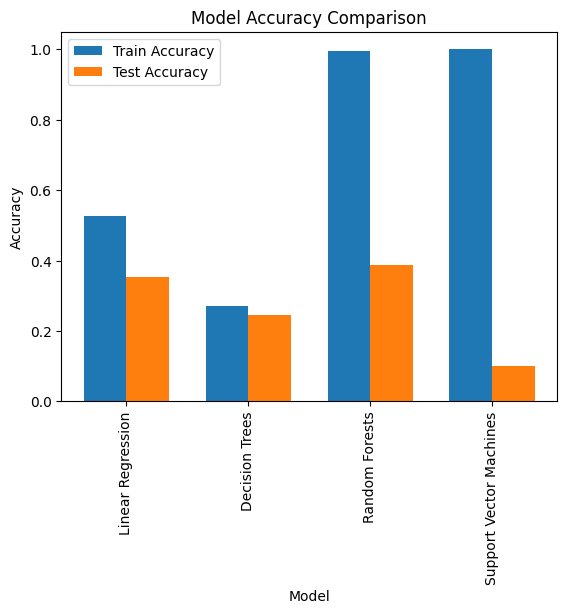

In [13]:
model_names = ['Linear Regression', 'Decision Trees', 'Random Forests', 'Support Vector Machines']
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(x, train_scores, bar_width, label='Train Accuracy') # training accuracy: don't forget to add labels
bar2 = ax.bar(x + bar_width, test_scores, bar_width, label='Test Accuracy') # testing accuracy

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
# set proper x ticks: I'll help you with this one
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names, rotation = 90)
ax.legend()

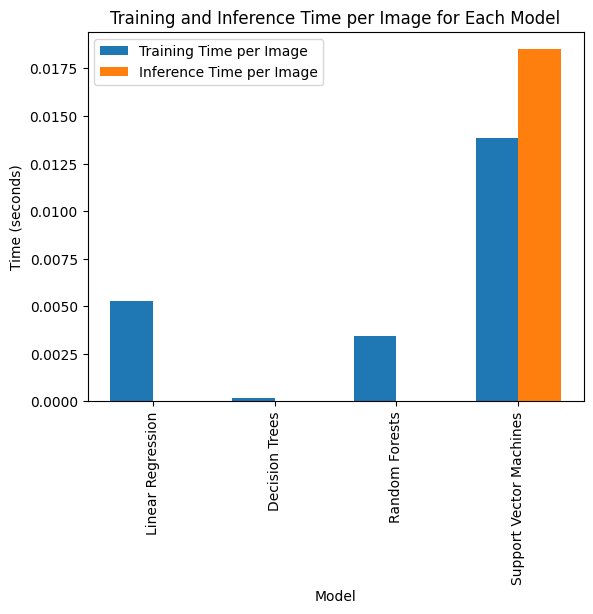

In [12]:
# Plotting the times
inference_test = [entry['test'] for entry in inf_times]
fig, ax = plt.subplots()
bar1 = ax.bar(x, fit_times, bar_width, label='Training Time per Image')
bar2 = ax.bar(x + bar_width, inference_test, bar_width, label='Inference Time per Image')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Inference Time per Image for Each Model')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names, rotation =90)
ax.legend()

plt.show()



**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?

1. Decision trees was the fastest model to train.
2. Similarly, it was also the fastest model to infer, as well as linear regression and random forests. Trees can be usually faster as its just traversing each node and making a decision.
3. Both Random Forest and Support Vector Machine had the higher train accuracies, approaching 1 and random forest also had the highest test accuracy, followed closely by linear regression.
4. I would use the Random Forest as it had reasonably low training time, very low inferring time while obtaining really high train score and the best test score as well.